# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1 : Propiedades en Venta</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [402]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('always')
from sklearn.model_selection import train_test_split

import geopandas as gp

In [403]:
dataset=pd.read_csv('./Datasets/properati_argentina_2021.csv').copy()
poly = gp.read_file(r'./Datasets/barrios.geojson')

# 1. Análisis Exploratorio y Preprocesamiento de Datos

### Exploración Inicial :

##### Primer análisis y seleccionamento de datos

In [404]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460154 entries, 0 to 460153
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        460154 non-null  object 
 1   start_date                460154 non-null  object 
 2   end_date                  460154 non-null  object 
 3   created_on                460154 non-null  object 
 4   latitud                   419740 non-null  float64
 5   longitud                  419740 non-null  float64
 6   place_l2                  460154 non-null  object 
 7   place_l3                  437665 non-null  object 
 8   place_l4                  139020 non-null  object 
 9   place_l5                  2430 non-null    object 
 10  place_l6                  0 non-null       float64
 11  operation                 460154 non-null  object 
 12  property_type             460154 non-null  object 
 13  property_rooms            368498 non-null  f

observamos que tenemos 460154 filas y 20 columnas

nos quedamos unicamente con las viviendas (Casa, PH, Departamento) en venta ubicadas en CABA cuyo precio esta en dólares.

In [405]:
viviendas = dataset[dataset.property_type.isin(['Casa', 'PH', 'Departamento'])].copy()  #deberiamos dejar la casa de campo?
viviendas_caba= viviendas[(viviendas.place_l2 == 'Capital Federal') & (viviendas.operation == 'Venta') & (viviendas.property_currency == 'USD')].copy()

volvemos a analizar el nuevo dataset

In [406]:
viviendas_caba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94249 entries, 25 to 460090
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        94249 non-null  object 
 1   start_date                94249 non-null  object 
 2   end_date                  94249 non-null  object 
 3   created_on                94249 non-null  object 
 4   latitud                   90519 non-null  float64
 5   longitud                  90519 non-null  float64
 6   place_l2                  94249 non-null  object 
 7   place_l3                  93832 non-null  object 
 8   place_l4                  3643 non-null   object 
 9   place_l5                  0 non-null      object 
 10  place_l6                  0 non-null      float64
 11  operation                 94249 non-null  object 
 12  property_type             94249 non-null  object 
 13  property_rooms            93205 non-null  float64
 14  prop

Vemos que ahora tenemos 94249 filas y 20 columnas

In [407]:
viviendas_caba[viviendas_caba.start_date != viviendas_caba.created_on].shape

(0, 20)

eliminamos columnas redundantes y vacias o que no nos sirven para nuestro analisis:
+ la columna created_on es identica a start_date
+ las columnas place_l2, operation y property_currency ya no son útiles ya que sus valores son todos identicos.
+ la columna id no nos aporta informaciión útil
+ las columnas place_l5 y place_l6 estan vacias


In [408]:
viviendas_caba.drop(columns=['created_on', 'place_l2', 'operation', 'property_currency', 'place_l5', 'place_l6', 'id'], inplace=True)
viviendas_caba.head()

,start_date,end_date,latitud,longitud,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
25,2021-09-09,2021-09-26,NaN,NaN,NaN,NaN,Casa,4.0,3.0,171.0,133.0,210000.0,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
42,2021-09-09,2021-09-26,-34.637319,-58.361124,Boca,NaN,Departamento,3.0,2.0,58.0,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO
43,2021-09-09,2021-09-28,-34.628647,-58.361871,Boca,NaN,Departamento,4.0,3.0,70.0,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur
49,2021-09-09,2022-01-05,-34.610027,-58.401934,Once,NaN,Departamento,4.0,2.0,NaN,104.0,146000.0,Venta departamento 4 ambientes Once
51,2021-09-09,2022-03-09,-34.631621,-58.416825,Boedo,NaN,PH,4.0,2.0,NaN,73.0,250000.0,PH - Boedo


Renombramos algunas columnas para representar mejor los datos

In [409]:
columnas={"place_l3":"barrio", 'place_l4':'vecindad'}
viviendas_caba.rename(columns = columnas, inplace = True)

convertimos a fecha las columnas start y end date

In [410]:
viviendas_caba.loc[:,"end_date"].replace(to_replace='9999-12-31',value='2200-12-31',inplace=True)
viviendas_caba['start_date'] = pd.to_datetime(viviendas_caba['start_date'], format='%Y/%m/%d %H:%M:%S.%f')
viviendas_caba['end_date'] = pd.to_datetime(viviendas_caba['end_date'], format='%Y/%m/%d %H:%M:%S.%f')

decidimos reeplazar la fecha de publicaciones no finalizadas por la fecha '2200-12-31' por cuestiones de implementacion de la funcion to_datetime

dividimos el dataset en entrenamiento y prueba.
En este caso vamos a entrenar utilizando el 80% de los datos y validando los modelos sobre el 20% de datos restantes.

In [411]:
viviendas_caba_train, viviendas_caba_test = train_test_split(viviendas_caba, test_size=0.2, random_state=2)
viviendas_caba_train_copy = viviendas_caba_train.copy()
viviendas_caba_train.head()

,start_date,end_date,latitud,longitud,barrio,vecindad,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
256070,2021-11-03,2022-02-02,-34.566536,-58.479638,Coghlan,NaN,Departamento,2.0,1.0,65.0,53.0,198000.0,1 - Holmberg 2700
27438,2021-12-03,2022-01-27,-34.645625,-58.459408,Flores,NaN,Departamento,1.0,NaN,29.0,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...
211207,2021-11-16,2021-11-18,NaN,NaN,Caballito,NaN,Departamento,2.0,1.0,41.0,35.0,93000.0,Departamento de 2 ambientes con balcón aterraz...
228948,2021-03-08,2021-06-05,-34.577033,-58.423367,Palermo,NaN,Departamento,1.0,1.0,49.0,44.0,160000.0,Departamento - Monoambiente - Palermo Nuevo - ...
361800,2021-01-16,2021-10-09,-34.580210,-58.412815,Palermo,NaN,Departamento,1.0,2.0,NaN,78.0,290000.0,Departamento en Palermo


##### Análisis medidas de resumen de variables cuantitativas:

In [412]:
medidas_de_resumen = viviendas_caba_train.describe()
medidas_de_resumen.drop(['count' , 'std', 'min', 'max'], axis=0, inplace=True)
moda = viviendas_caba_train.mode()
moda.head(10)
moda.index = ['mode']

moda.drop(['barrio', 'vecindad','property_type','property_title'], axis = 1, inplace = True) 

medidas_de_resumen = pd.concat([medidas_de_resumen, moda])
medidas_de_resumen

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,start_date,end_date
mean,-34.591125,-58.450693,2.822798,2.015567,112.53916,90.110213,227331.542381,NaT,NaT
25%,-34.615979,-58.466523,2.000000,1.000000,45.00000,40.000000,95000.000000,NaT,NaT
50%,-34.595749,-58.439042,3.000000,2.000000,65.00000,57.000000,144000.000000,NaT,NaT
75%,-34.577395,-58.408935,4.000000,3.000000,105.00000,89.000000,235000.000000,NaT,NaT
mode,-34.541250,-58.472966,3.000000,1.000000,50.00000,40.000000,110000.000000,2021-12-16,2021-06-05


##### Análisis graficamente distribucion de variables cuantitativas

In [413]:
"""pairplot_fig = sns.pairplot(viviendas_caba_train, hue='property_type').figure
pairplot_fig.savefig('./Figures/paiplot') """

"pairplot_fig = sns.pairplot(viviendas_caba_train, hue='property_type').figure\npairplot_fig.savefig('./Figures/paiplot') "

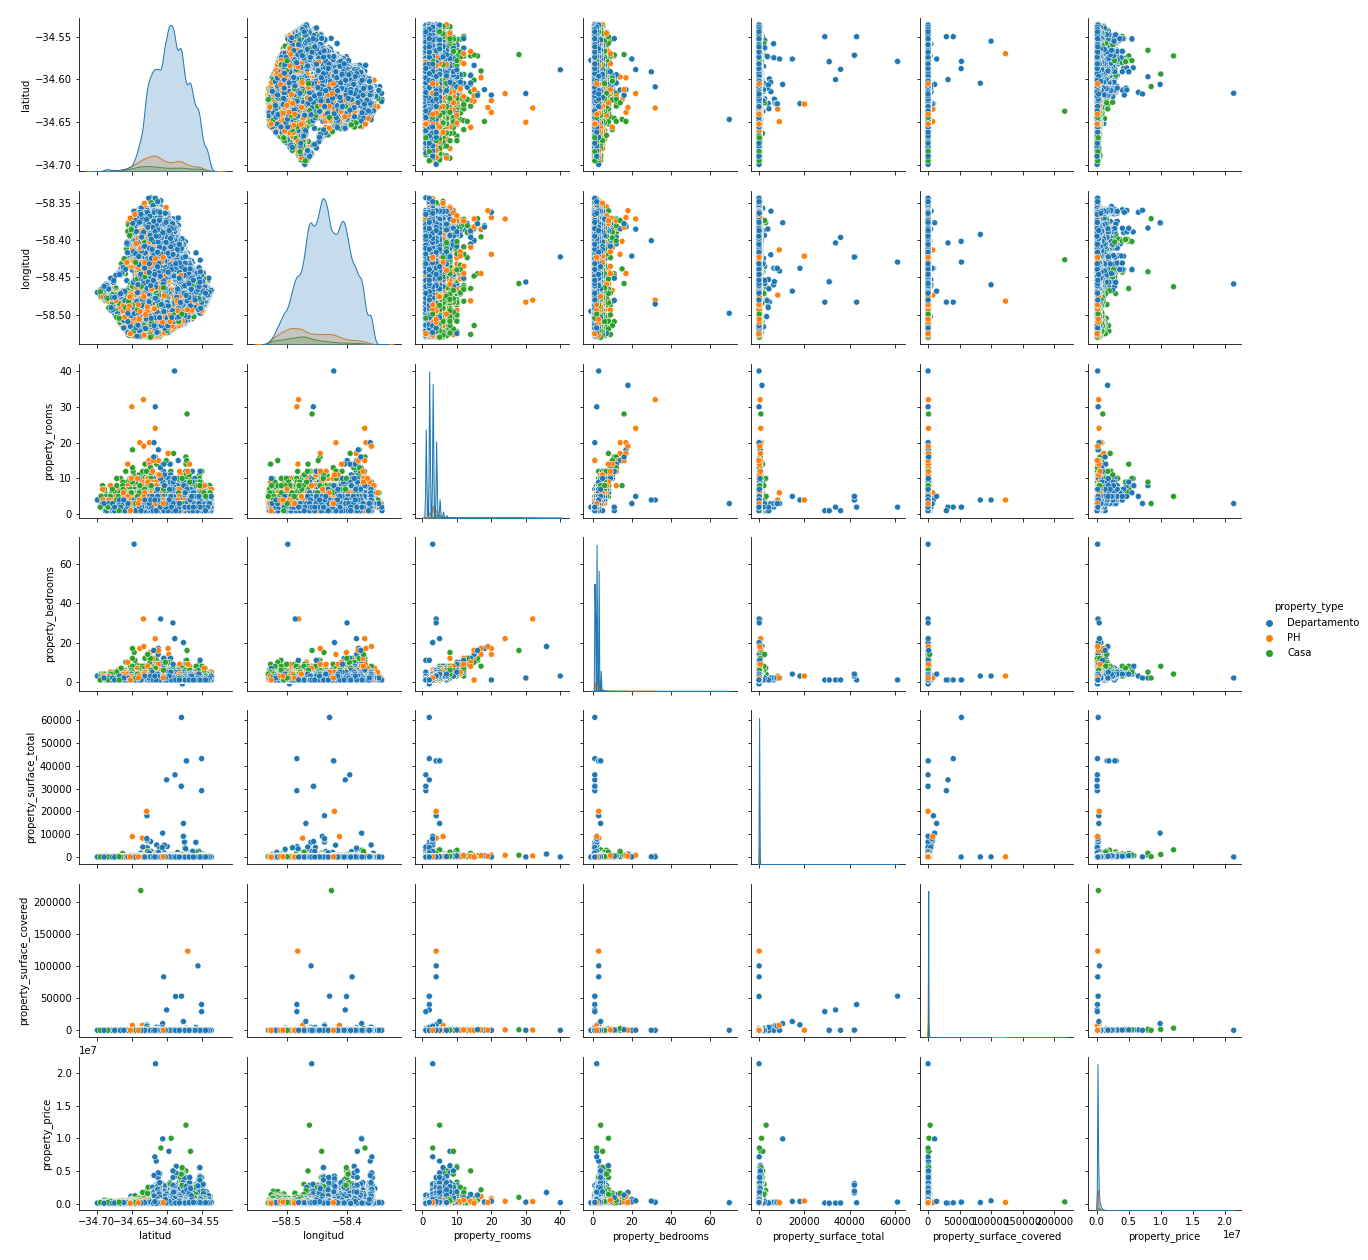

In [414]:
from IPython.display import Image
Image(filename = './Figures/paiplot.png', width=1500, height=1500)

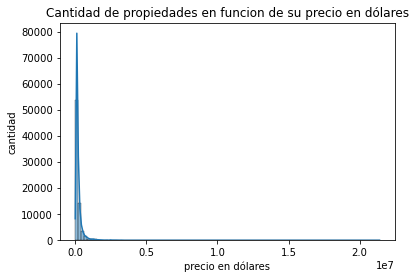

In [415]:
sns_hist = sns.histplot(data=viviendas_caba_train['property_price'], kde=True, alpha = 0.5, bins=100).set(title="Cantidad de propiedades en funcion de su precio en dólares",xlabel="precio en dólares",ylabel="cantidad")

podemos ver que hay precios muy elevados que se alejan de lo habitual

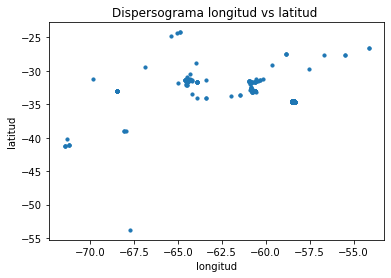

In [416]:
grf_long_lat=viviendas_caba_train.plot.scatter(x="longitud", y="latitud", s=10).set(title="Dispersograma longitud vs latitud ",xlabel='longitud',ylabel='latitud')

Aca ya podemos ver que hay puntos que no estan dentro de la lat y long de caba, es decir outliers que tendremos que procesar    

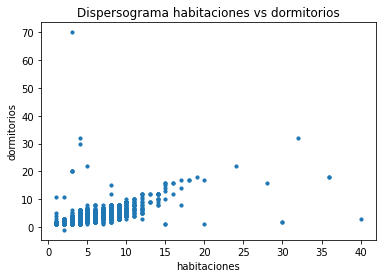

In [417]:
grf_dormitorios_por_habitaciones=viviendas_caba_train.plot.scatter(x="property_rooms", y="property_bedrooms", s=10).set(title="Dispersograma habitaciones vs dormitorios",xlabel='habitaciones',ylabel='dormitorios') 

vemos que hay algunos que todos los que estan por encima de la diagonal tienen mas dormitorios que habitaciones por lo que deben estar mal

In [418]:
def ventas_por_mes(fila):
    return viviendas_caba_train.loc[fila].end_date.month

cantidad_de_ventas_por_mes = viviendas_caba_train.end_date.groupby(by=ventas_por_mes).count()

<AxesSubplot:title={'center':'cantidad de ventas por mes'}, xlabel='mes', ylabel='cantidad de ventas'>

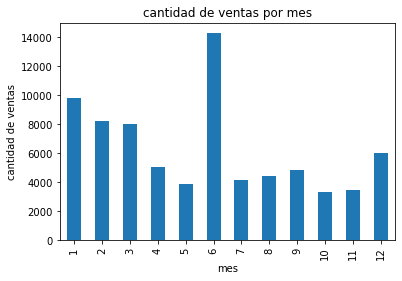

In [419]:
cantidad_de_ventas_por_mes.plot.bar(title="cantidad de ventas por mes" , xlabel="mes" , ylabel="cantidad de ventas")

vemos que junio fue el mes con mayor numero de ventas

<AxesSubplot:title={'center':'ventas por mes'}, xlabel='mes', ylabel='dólares'>

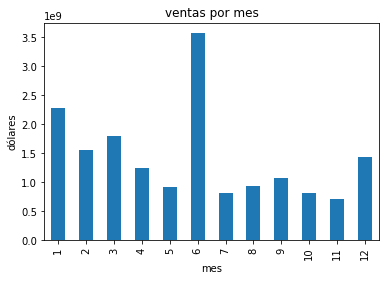

In [420]:
ventas_por_mes = viviendas_caba_train.groupby(by=ventas_por_mes).property_price.sum()

ventas_por_mes.plot.bar(title="ventas por mes" , xlabel="mes" , ylabel="dólares")

vemos que el grafico tiene una gran correlacion con el de cantidad de ventas por mes, lo cual tiene sentido

<AxesSubplot:title={'center':'Cantidad de viviendas por barrio'}, xlabel='barrio', ylabel='cantidad'>

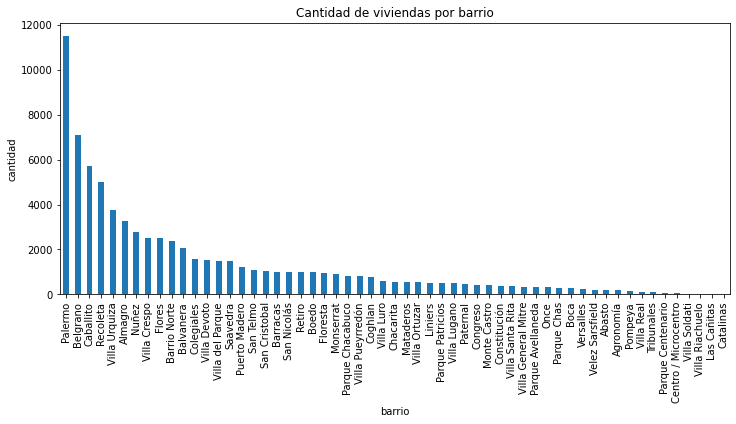

In [421]:
viviendas_caba_train.barrio.value_counts().plot.bar(figsize=(12,5),title="Cantidad de viviendas por barrio" , xlabel="barrio" , ylabel="cantidad")

<AxesSubplot:title={'center':'Cantidad de viviendas por vecindario'}, xlabel='vecindario', ylabel='cantidad'>

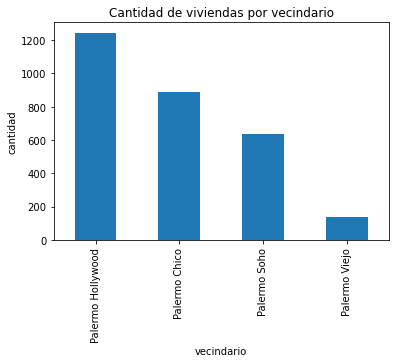

In [422]:
viviendas_caba_train.vecindad.value_counts().plot.bar(title="Cantidad de viviendas por vecindario" , xlabel="vecindario" , ylabel="cantidad")

Como solo palermo tiene vecindarios cargados tenemos que tomar una desicion. O los consideramos a todos como parlermo, o en veez de considerar 58 barrios consieramos 63 barrios y sacamos las vecindades y los metemos en los barrios.

<AxesSubplot:title={'center':'promedio de precios por barrio'}, xlabel='barrio', ylabel='promedio de precios'>

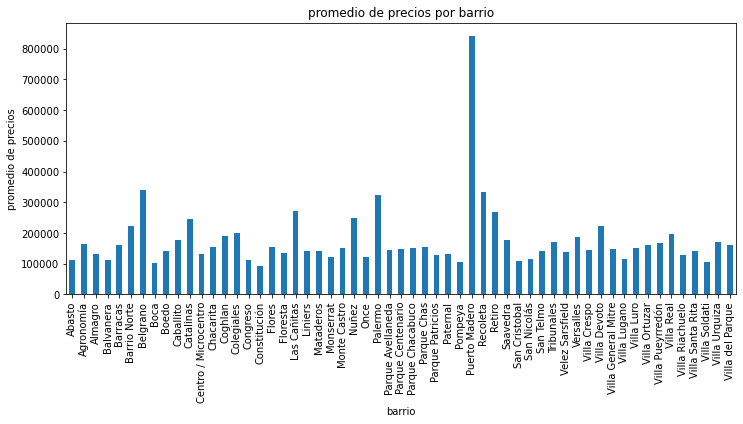

In [423]:
viviendas_caba_train.groupby('barrio')['property_price'].mean().plot.bar(figsize=(12,5), title="promedio de precios por barrio" , xlabel="barrio" , ylabel="promedio de precios")

a simple vista pareciera que hay barrios mas caros que otros

<AxesSubplot:title={'center':'promedio de superficie total por por barrio'}, xlabel='barrio', ylabel='promedio de superfiecie total'>

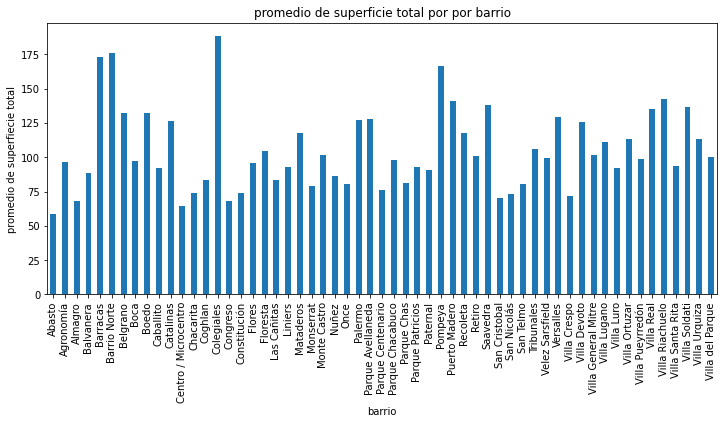

In [424]:
viviendas_caba_train.groupby('barrio')['property_surface_total'].mean().plot.bar(figsize=(12,5), title="promedio de superficie total por por barrio" , xlabel="barrio" , ylabel="promedio de superfiecie total")

vemos que en cuanto tama;o hjay una distribucion bastante pareja

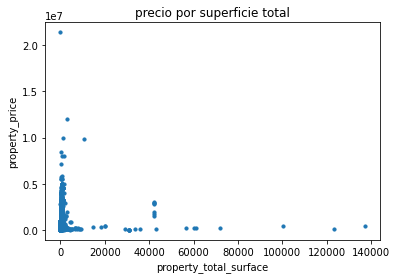

In [425]:
grf_precio_por_superficie=viviendas_caba_train.plot.scatter(x="property_surface_total", y="property_price", s=10).set(title="precio por superficie total",xlabel='property_total_surface',ylabel='property_price') 

Outliers no dejan sacar mucha info del grafico.

##### Correlación entre variables

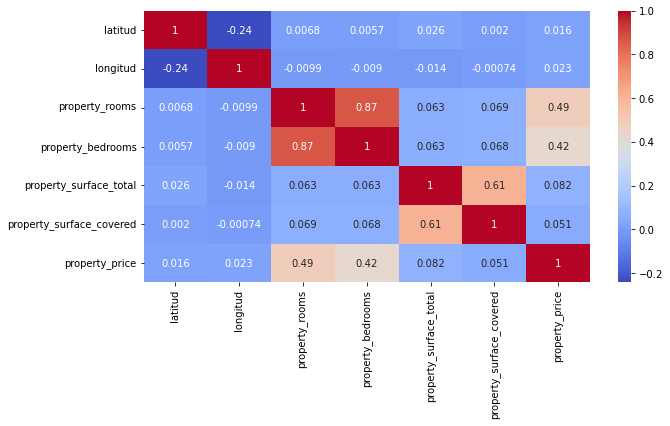

In [426]:
matriz_correlacion=viviendas_caba_train.corr()

plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacion, annot = True,cmap = 'coolwarm')
plt.show()

Despues de realiza el grafico de correlaciones, vemos que ademas de las relaciones obias, como cantidad de cuartos con cantidad de habitaciones y la superficie total con la superficie cubierta. Ademas podemos notar una leve correlacion entre el precio y la cantidad de habitaciones

##### Conlusiones generales del análisis Exploratorio

Vendemos mayormente deptos, hay datos erroneos que estan por fuera de la lat y long de caba. 
Se suele vender propiedades con pocas habitaciones y a su vez que hay propiedades con mas dormitorios que habitaciones lo cual carece de sentido. 
Los barrios con mas propiedades en venta son Palermo, Belgrano y Caballito. En catalania se vende poco zona de oficina.
Hay propiedades con mucha mas superficie cubierta que total, es decir edificios.
Todos los graficos y conclusiones vistas hasta ahora, se ven afectadas por datos faltantes, redudantes y outliers.

### Datos Faltantes :

##### Datos faltantes a nivel columna:

Al principio de la notebook ya eliminamos dos columnas, l_5 y l_6, ya no contaban con ningun dato. Ahora examinaremos el resto de las columnas

<AxesSubplot:title={'center':'porcentaje de datos faltantes por categoria'}, xlabel='categoria', ylabel='porcentaje'>

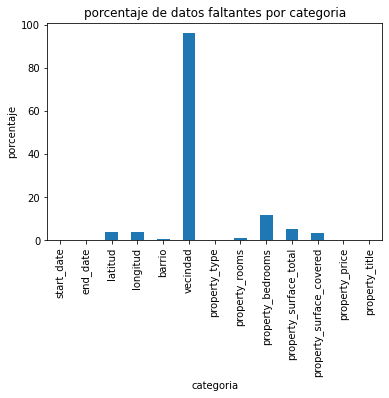

In [427]:
((viviendas_caba_train.isna().sum())/viviendas_caba_train.shape[0]*100).plot.bar(xlabel = 'categoria', ylabel = 'porcentaje', title = 'porcentaje de datos faltantes por categoria')

##### Datos faltantes a nivel fila:

<AxesSubplot:title={'center':'porcentaje de datos faltantes por fila'}, xlabel='cantidad de datos faltantes', ylabel='porcentaje'>

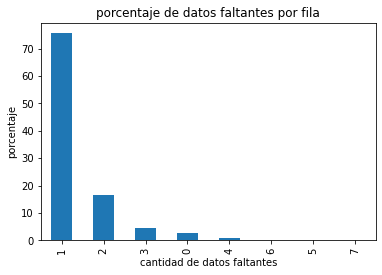

In [428]:
((viviendas_caba_train.isnull().sum(axis=1).value_counts())/viviendas_caba_train.shape[0]*100).plot.bar(xlabel = 'cantidad de datos faltantes', ylabel = 'porcentaje', title = 'porcentaje de datos faltantes por fila')

vemos que tenemos un gran porcentaje de filas que tienen un solo dato faltante

### Reparación de datos:

#### Quitamos columnas no utiles:

Lo primero que vemos que mas llama la atencion es la vecindad que tiene mas del 96% de datos faltantes. Como habiamos visto mas arriba los unicos datos que tiene esta columna provienen de parlermo. Para tratar estos datos faltantes notamos 3 opciones. Eliminar la columna enteramente, imputar los datos correspondientes a palermo eliminar la columna pero en vez de tener en la columna barrio a Palermo, tener las 4 vecinadades. O si no tener 5 barrios que representen a parlemo, uno generico y las 4 vecindades. Decidimos eliminar de lleno a la columa ya que era muy grande el porcentaje de datos faltantes.

In [429]:
viviendas_caba_train.drop(columns=['vecindad'], inplace=True)

Luego de eliminar la vecindad volvemos  agraficar para ver el estado actual de los datos faltantes 

<AxesSubplot:title={'center':'porcentaje de datos faltantes por fila'}, xlabel='cantidad de datos faltantes', ylabel='porcentaje'>

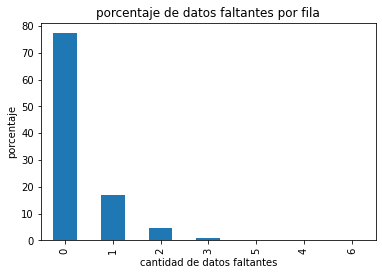

In [430]:
((viviendas_caba_train.isnull().sum(axis=1).value_counts())/viviendas_caba_train.shape[0]*100).plot.bar(xlabel = 'cantidad de datos faltantes', ylabel = 'porcentaje', title = 'porcentaje de datos faltantes por fila')

vemos que casi un 80% de nuestras filas no tienen datos faltantes

<AxesSubplot:title={'center':'porcentaje de datos faltantes por categoria'}, xlabel='categoria', ylabel='porcentage'>

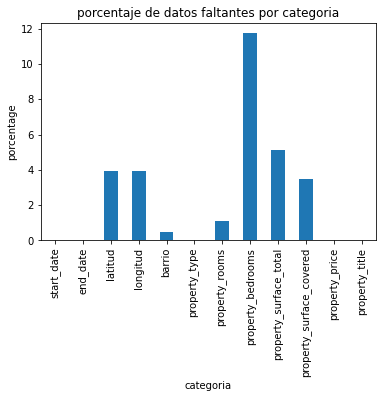

In [431]:
((viviendas_caba_train.isna().sum())/viviendas_caba_train.shape[0]*100).plot.bar(xlabel = 'categoria', ylabel = 'porcentage', title = 'porcentaje de datos faltantes por categoria')

#### Limpieza de viviendas fuera de CABA por coordenadas

Creamos un geodataframe con los filas del original que si tienen lat y long

In [432]:
import shapely.speedups
shapely.speedups.enable()
con_lat_y_lon = viviendas_caba_train.copy().loc[(viviendas_caba["latitud"].notna()) & (viviendas_caba["longitud"].notna())] 
con_lat_y_lon = gp.GeoDataFrame(con_lat_y_lon, geometry=gp.points_from_xy(con_lat_y_lon.longitud, con_lat_y_lon.latitud))

Unimos todos los barrios de CABA para formar una GeoSerie con el poligono de CABA

C:\Users\iankl\AppData\Local\Temp\ipykernel_6036\2859399624.py:3: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  caba_poly = gp.GeoSeries(cascaded_union(polygons))


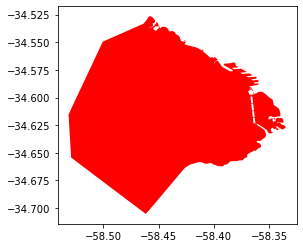

In [433]:
from shapely.ops import cascaded_union
polygons = poly.geometry.to_list()
caba_poly = gp.GeoSeries(cascaded_union(polygons))
caba_poly.plot(color = 'red')
plt.show()


Creamos una mascara para distinguir las viviendas que estan fuera y dentro del poligono de CABA (como crear la mascara es un proceso muy demandante la guardamos en un archivo CSV y la dejamos comentada por si acaso)

In [434]:
"""creo un vector true/false si la vivienda está en el barrio (interseccion punto con poligono)
mask = con_lat_y_lon.within(caba_poly.iloc[0]) 
mask.to_csv('./Datasets/en_caba_mask.csv', index = True, header=None)"""

"creo un vector true/false si la vivienda está en el barrio (interseccion punto con poligono)\nmask = con_lat_y_lon.within(caba_poly.iloc[0]) \nmask.to_csv('./Datasets/en_caba_mask.csv', index = True, header=None)"

leemos la mascara y generamos un dataset para viviendas dentro de caba y otro para las de fuera

In [435]:
mask = pd.read_csv('./Datasets/en_caba_mask.csv', header=None, names=['index', 'bool']).copy()
mask.set_index('index',inplace=True)

viviendas_en_caba = con_lat_y_lon.loc[mask['bool']]
viviendas_fuera_de_caba = con_lat_y_lon.loc[~mask['bool']]

In [436]:
print(f'numero de filas de viviendas con latitud y longitud: {con_lat_y_lon.shape[0]}')
print(f'numero de filas de viviendas con latitud y longitud en caba: {viviendas_en_caba.shape[0]}')
print(f'numero de filas de viviendas con latitud y longitud fuera de caba: {viviendas_fuera_de_caba.shape[0]}')

numero de filas de viviendas con latitud y longitud: 72416
numero de filas de viviendas con latitud y longitud en caba: 72243
numero de filas de viviendas con latitud y longitud fuera de caba: 173


hacemos un ansalis visual de las viviendas fuera de caba para ver si es correcto eliminarlas

In [437]:
viviendas_fuera_de_caba.tail(3)

,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,geometry
45536,2021-05-02,2021-06-05,-32.065926,-64.527838,NaN,Casa,3.0,2.0,307.0,106.0,139000.0,Se Vende Casa Amoblada en Santa Rosa de Calamu...,POINT (-64.52784 -32.06593)
54727,2021-01-11,2021-02-09,-31.664340,-63.885916,NaN,Casa,5.0,4.0,NaN,145.0,190000.0,VENTA CASA CON PILETA Y COCHERA - B° PRIVADO,POINT (-63.88592 -31.66434)
229657,2021-07-27,2022-06-04,-38.958207,-67.923565,NaN,Casa,NaN,3.0,330.0,150.0,95000.0,VENDE CASA 3 dormitorios en Barrio Los Frutale...,POINT (-67.92357 -38.95821)


concluimos en que está bien eliminarlas del dataset de entrenamiento

In [438]:
print(viviendas_caba_train.shape)
viviendas_caba_train.drop(viviendas_fuera_de_caba.index, axis=0, inplace=True)
print(viviendas_caba_train.shape)

(75399, 12)
(75226, 12)


Para analizar el cambio graficamente graficamos primero el mapa con todas las viviendas y luego el mapa con unicamente las viviendas de CABA 

<AxesSubplot:>

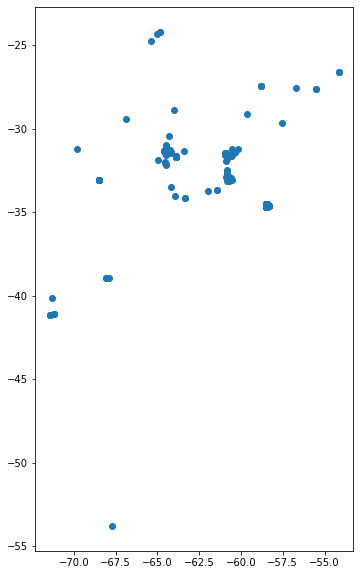

In [439]:
fig, ax = plt.subplots(figsize=(10,10))
poly.plot(ax=ax,column='BARRIO',alpha=0.5)
con_lat_y_lon.plot(ax=ax)

<AxesSubplot:>

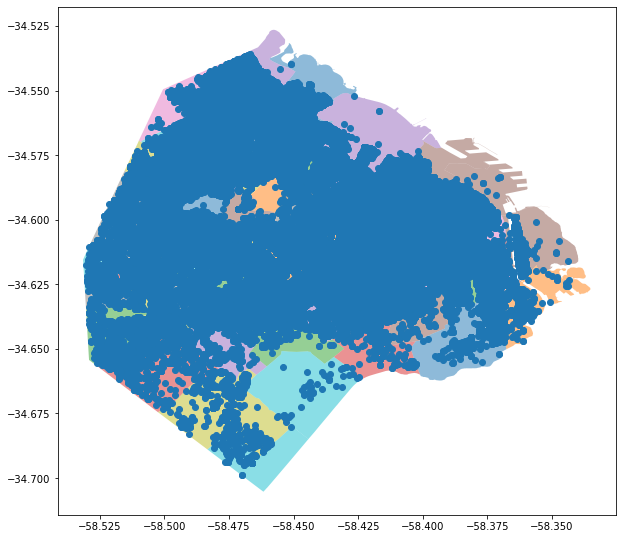

In [440]:
fig, ax = plt.subplots(figsize=(10,10))
poly.plot(ax=ax,column='BARRIO',alpha=0.5)
viviendas_en_caba.plot(ax=ax)

#### Reparacíon de barrios faltantes por coordenadas

Vemos que hay propiedades que no tienen barrio:

In [441]:
viviendas_caba_train[viviendas_caba_train.barrio.isna()].longitud.notna().sum() #VER QUE ONDA LA JUSTIFICACION DE ABAJO

40

creamos un nuevo GeoDataSet con todas las viviendas que tienen coordenadas pero no barrio

In [442]:
sin_barrio_con_coord = viviendas_caba_train.copy().loc[(viviendas_caba_train["barrio"].isna()) & (viviendas_caba_train["latitud"].notna()) & (viviendas_caba_train["longitud"].notna())] 
sin_barrio_con_coord = gp.GeoDataFrame(sin_barrio_con_coord, geometry=gp.points_from_xy(sin_barrio_con_coord.longitud, sin_barrio_con_coord.latitud))

In [443]:
con_barrio_por_coordenadas = sin_barrio_con_coord.copy()
for barrio in poly.BARRIO:
    indice_barrio = poly[poly['BARRIO'] == barrio].index[0] 
    mask = sin_barrio_con_coord.within(poly.loc[indice_barrio, 'geometry']) 
    con_barrio_por_coordenadas.loc[mask,"barrio"] = barrio

graficamos las viviendas a las que se les agregó un barrio

<AxesSubplot:>

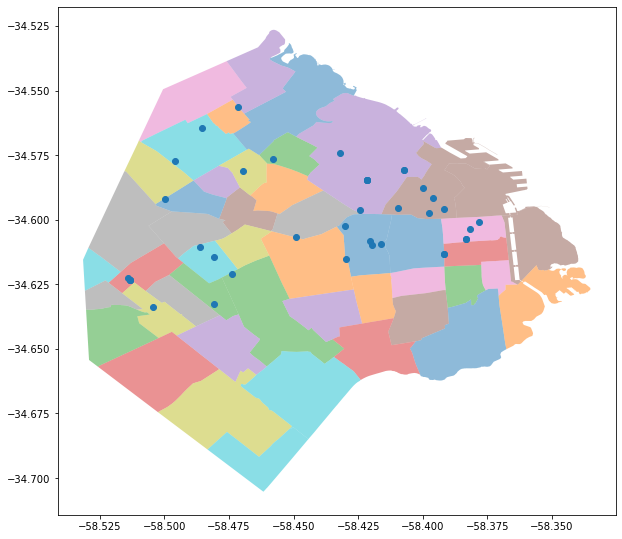

In [444]:
mapa_barrios_completados = gp.GeoDataFrame(con_barrio_por_coordenadas, geometry=gp.points_from_xy(con_barrio_por_coordenadas.longitud, con_barrio_por_coordenadas.latitud))
fig, ax = plt.subplots(figsize=(10,10))
poly.plot(ax=ax,column='BARRIO',alpha=0.5)
mapa_barrios_completados.plot(ax=ax)

In [445]:
print(f'cantidad de viviendas sin barrio y con coordenadas: {sin_barrio_con_coord.barrio.isna().sum()}')
print(f'cantidad de barrios que no se pudieron completar: {con_barrio_por_coordenadas.barrio.isna().sum()}')

cantidad de viviendas sin barrio y con coordenadas: 40
cantidad de barrios que no se pudieron completar: 0


vemos que hemos podido completar exitosamente todos los barrios de las viviendas que tenían coordenadas por lo que pasaremos estos datos al dataset de entrenamiento, por lo que proseguimos a mostrarlo y completarlo en el original

In [446]:
print(f' cantidad de viviendas sin barrio: {viviendas_caba_train.barrio.isna().sum()}')
viviendas_caba_train[viviendas_caba_train.index == 190496]

 cantidad de viviendas sin barrio: 179


,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
190496,2021-10-09,2200-12-31,-34.615136,-58.429657,NaN,Departamento,2.0,NaN,59.0,38.0,115000.0,Departamento venta


In [447]:
con_barrio_por_coordenadas.drop("geometry", axis = 1, inplace = True)
viviendas_caba_train.loc[con_barrio_por_coordenadas.index] = con_barrio_por_coordenadas 

In [448]:
print(f' cantidad de viviendas sin barrio: {viviendas_caba_train.barrio.isna().sum()}')
viviendas_caba_train[viviendas_caba_train.index == 190496]

 cantidad de viviendas sin barrio: 139


,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
190496,2021-10-09,2200-12-31,-34.615136,-58.429657,ALMAGRO,Departamento,2.0,NaN,59.0,38.0,115000.0,Departamento venta


#### Reparación de cantidad de dormitorios en base a cantidad de habitaciones

##### Tratamos outliers rooms

Anteriormente vimos que la relacion entre cantidad de dormitorios y habitaciones era bastante lineal. Por lo que podemos completar datos faltantes utilizando una regresión lineal. Como la regresion lineal es muy sensibe a los valores atipicos primero debemos tratarlos.
Comenzamos buscando estos valores atípicos:

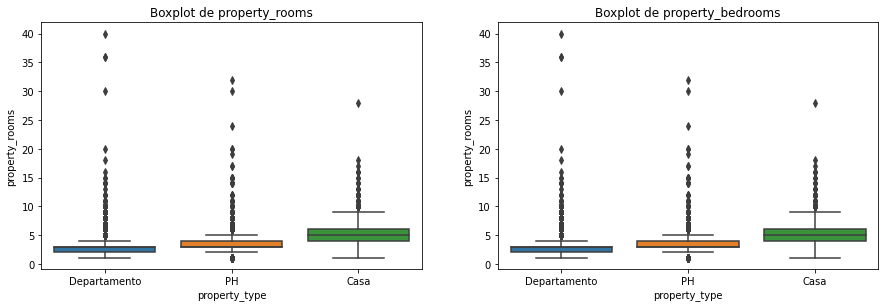

In [449]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(x=viviendas_caba_train_copy.property_type, y=viviendas_caba_train_copy.property_rooms).set(title = 'Boxplot de property_rooms' )
plt.subplot(222)
sns.boxplot(x=viviendas_caba_train_copy.property_type, y=viviendas_caba_train_copy.property_rooms).set(title = 'Boxplot de property_bedrooms' )
plt.show()

pensamos en sacar a todas las viviendas que esten por fuera de 1.5*IQR

In [450]:
#Calculo los cuantiles de las variables rooms_dep,rooms_ph,rooms_casa
viviendas_con_rooms = viviendas_caba_train[viviendas_caba_train.property_rooms.notna()]


rooms_dep_q3, rooms_dep_q1 = np.percentile(viviendas_con_rooms[viviendas_con_rooms.property_type == 'Departamento'].property_rooms, [75 ,25])
rooms_ph_q3, rooms_ph_q1 = np.percentile(viviendas_con_rooms[viviendas_con_rooms.property_type == 'PH'].property_rooms, [75 ,25])
rooms_casa_q3, rooms_casa_q1 = np.percentile(viviendas_con_rooms[viviendas_con_rooms.property_type == 'Casa'].property_rooms, [75 ,25])

#Calculo e rango intercuartil de las variables x,y,z
iqr_dep = rooms_dep_q3 - rooms_dep_q1
iqr_ph = rooms_ph_q3 - rooms_ph_q1
iqr_casa = rooms_casa_q3 - rooms_casa_q1

print(iqr_dep,iqr_ph,iqr_casa)

1.0 1.0 2.0


In [451]:
deptos_que_quedan= viviendas_con_rooms[viviendas_con_rooms.property_type == 'Departamento'].query(' property_rooms >= (@rooms_dep_q1 - @iqr_dep*1.5) & property_rooms <= (@rooms_dep_q3 + @iqr_dep*1.5) ')
print(deptos_que_quedan.shape)
print(viviendas_con_rooms[viviendas_con_rooms.property_type == 'Departamento'].shape)

(60190, 12)
(64120, 12)


Nos dimos cuenta que este no es un buen criterio a tomar, porque estariamos eliminando demasiadas viviendas que aunque tengas más habitaciones de lo normal y sean outliers, no parecen algo fuera de lo posible o razonable. Es por esto que decidimos utilizar criterios simples usando el sentido comun, como que consideramos atipicos a departamentos con mas de 10 habitacions, casas con mas de 20, y ph 15. 
Primero pensamos en tratar a algunos de esos outliers manuelmente, corrigiendo algunos errores de carga, sin embargo optamos por eliminarlos, ya que no nos parecio adecuado, tener que cada vez que se agrande el dataset, tener que ver esos datos. (VER SI QUEDA O NO QUEDA)

In [452]:
deptos_a_borrar = viviendas_caba_train[(viviendas_caba_train.property_type == 'Departamento') & (viviendas_caba_train.property_rooms >10)]
ph_a_borrar = viviendas_caba_train[(viviendas_caba_train.property_type == 'PH') & (viviendas_caba_train.property_rooms >15)]
casas_a_borrar =  viviendas_caba_train[(viviendas_caba_train.property_type == 'Casa') & (viviendas_caba_train.property_rooms >20)]

viviendas_a_borrar = pd.concat([deptos_a_borrar, ph_a_borrar, casas_a_borrar])
viviendas_caba_train.drop(viviendas_a_borrar.index, axis=0,inplace=True)

Para verificar la distribucion tras eliminar los outliers, comparamos los boxplot de antes de eliminarlos con el dataset de los ya eliminados.

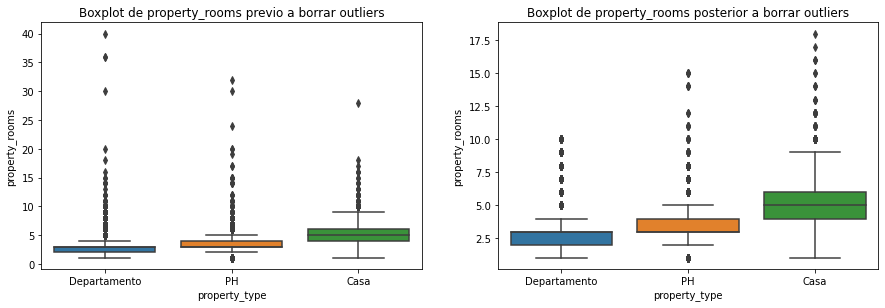

In [453]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(x=viviendas_caba_train_copy.property_type, y=viviendas_caba_train_copy.property_rooms).set(title = 'Boxplot de property_rooms previo a borrar outliers' )
plt.subplot(222)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_rooms).set(title = 'Boxplot de property_rooms posterior a borrar outliers' )
plt.show()

Podemos vercomo ahora los cuartiles mejor representados sin la presencia de los outliers.

##### Tratamos outliers bedrooms:

repetimos el procesos anmterior para los bedrooms

Decimos que considerariamos outliers a aquellos departamentos que tengan 9 bedrooms, phs con 13, casas con 18. Esto es debido a que viviendas tan grandes deben tener algun cuarto, ya sea el ba;o o la cocina que no son bedrooms

In [454]:
deptos_a_borrar = viviendas_caba_train[(viviendas_caba_train.property_type == 'Departamento') & (viviendas_caba_train.property_bedrooms >9)]
ph_a_borrar = viviendas_caba_train[(viviendas_caba_train.property_type == 'PH') & (viviendas_caba_train.property_bedrooms >13)]
casas_a_borrar =  viviendas_caba_train[(viviendas_caba_train.property_type == 'Casa') & (viviendas_caba_train.property_bedrooms >18)]

viviendas_a_borrar = pd.concat([deptos_a_borrar, ph_a_borrar, casas_a_borrar])
viviendas_caba_train.drop(viviendas_a_borrar.index, axis=0,inplace=True)

Para verificar la distribucion tras eliminar los outliers, comparamos los boxplot de antes de eliminarlos con el dataset de los ya eliminados.

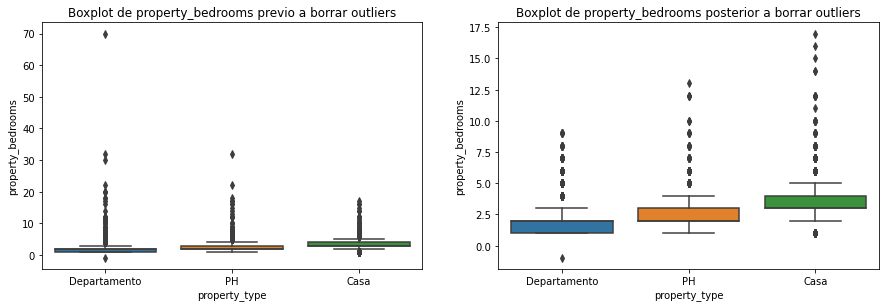

In [455]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(x=viviendas_caba_train_copy.property_type, y=viviendas_caba_train_copy.property_bedrooms).set(title = 'Boxplot de property_bedrooms previo a borrar outliers' )
plt.subplot(222)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_bedrooms).set(title = 'Boxplot de property_bedrooms posterior a borrar outliers' )
plt.show()

Una vez limpios los valores atípicos, podemos inputar datos sobre cantidad de dormitorios en base a la cantidad de habitaciones utilizando regresion lineal

In [456]:
from sklearn.linear_model import LinearRegression
#Creo un regresor lineal
modelo_regresion_lineal_simple = LinearRegression()

#Doy el formato adecuado a las variables dependiente e independiente

aux = viviendas_caba_train[viviendas_caba_train.property_rooms.notna() & viviendas_caba_train.property_bedrooms.notna()]

x=aux.property_rooms.values
y=aux.property_bedrooms.values

x_=x.reshape(-1, 1)
y_=y.reshape(-1, 1)

#Ajusto el modelo
modelo_regresion_lineal_simple.fit(x_,y_)

#Parámetros estimados
B1_e=round(modelo_regresion_lineal_simple.coef_[0][0],2) #coef = pendiente
B0_e=round(modelo_regresion_lineal_simple.intercept_[0],2) #intercept = ordenada al origen

#Muestro el modelo
print(f" El modelo lineal simple ajustado es : y = {B1_e} * X  + {B0_e}")

 El modelo lineal simple ajustado es : y = 0.73 * X  + -0.22


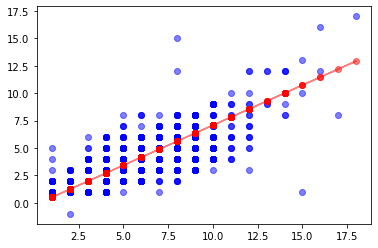

In [457]:
#Calculo los valores que estima mi modelo lineal simple

y_e=B1_e *x_ + B0_e

#Grafico las observaciones reales + las estimadas
plt.scatter(x,y,label='data', color='blue',alpha=0.5)
plt.plot(x_,y_e,label='data', color='red',alpha=0.5)
plt.scatter(x_,y_e,label='data', color='red',alpha=0.5)

##### Imputamos bedrooms a base de rooms

In [458]:
sin_bedroom_con_room = viviendas_caba_train[viviendas_caba_train.property_rooms.notna() & viviendas_caba_train.property_bedrooms.isna()]
sin_bedroom_con_room.head()

,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
27438,2021-12-03,2022-01-27,-34.645625,-58.459408,Flores,Departamento,1.0,NaN,29.0,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...
155007,2021-02-03,2022-05-15,NaN,NaN,Villa Crespo,Departamento,1.0,NaN,47.0,32.0,66780.0,VENTA - Departamento en pozo- Villa Crespo
163967,2021-06-07,2021-10-08,-34.579829,-58.433008,Palermo,Departamento,1.0,NaN,41.0,30.0,99500.0,Departamento Venta - Palermo Hollywood
310141,2021-09-01,2022-03-04,-34.570436,-58.434466,Palermo,Departamento,1.0,NaN,42.0,37.0,150000.0,Departamento 1 Amb. c/Cochera - Las Cañitas
137226,2021-01-22,2021-06-30,-34.582098,-58.448859,Palermo,Departamento,1.0,NaN,33.0,28.0,104892.0,Venta - Newbery Jorge 3445 9º F Jardin


Con esto obtuvimos un modelo lineal para predecir la cantidad de dormitorios en funcion de la cantidad de cuartos, de la forma cantidadDeBedrooms = 0.72 * cantidadDeRooms - 0.17

In [459]:
sin_bedroom_con_room.property_bedrooms = ((sin_bedroom_con_room.property_rooms*B1_e) +B0_e).round()
sin_bedroom_con_room.head()

C:\Users\iankl\AppData\Local\Temp\ipykernel_6036\2610459576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_bedroom_con_room.property_bedrooms = ((sin_bedroom_con_room.property_rooms*B1_e) +B0_e).round()


,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
27438,2021-12-03,2022-01-27,-34.645625,-58.459408,Flores,Departamento,1.0,1.0,29.0,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...
155007,2021-02-03,2022-05-15,NaN,NaN,Villa Crespo,Departamento,1.0,1.0,47.0,32.0,66780.0,VENTA - Departamento en pozo- Villa Crespo
163967,2021-06-07,2021-10-08,-34.579829,-58.433008,Palermo,Departamento,1.0,1.0,41.0,30.0,99500.0,Departamento Venta - Palermo Hollywood
310141,2021-09-01,2022-03-04,-34.570436,-58.434466,Palermo,Departamento,1.0,1.0,42.0,37.0,150000.0,Departamento 1 Amb. c/Cochera - Las Cañitas
137226,2021-01-22,2021-06-30,-34.582098,-58.448859,Palermo,Departamento,1.0,1.0,33.0,28.0,104892.0,Venta - Newbery Jorge 3445 9º F Jardin


In [460]:
print(f'cantidad de dormitorios faltantes: {viviendas_caba_train.property_bedrooms.isna().sum()}')
viviendas_caba_train[viviendas_caba_train.index == 27438]

cantidad de dormitorios faltantes: 8835


,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
27438,2021-12-03,2022-01-27,-34.645625,-58.459408,Flores,Departamento,1.0,NaN,29.0,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...


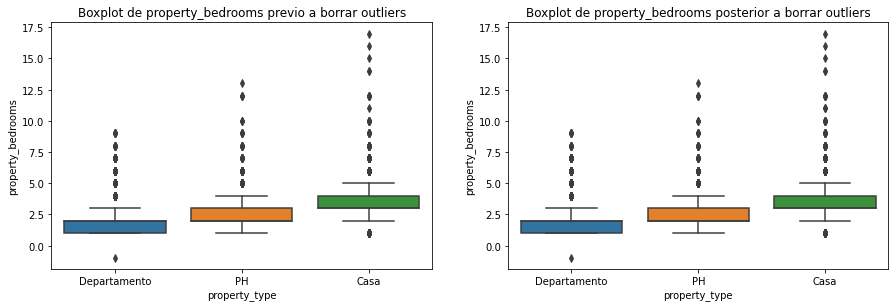

In [461]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_bedrooms).set(title = 'Boxplot de property_bedrooms previo a imputar bedrooms' )

#IMPUTAMOS
viviendas_caba_train.loc[sin_bedroom_con_room.index] = sin_bedroom_con_room 

plt.subplot(222)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_bedrooms).set(title = 'Boxplot de property_bedrooms posterior a imputar bedrooms' )
plt.show()

In [462]:
print(f'cantidad de dormitorios faltantes: {viviendas_caba_train.property_bedrooms.isna().sum()}')
viviendas_caba_train[viviendas_caba_train.index == 27438]

cantidad de dormitorios faltantes: 346


,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
27438,2021-12-03,2022-01-27,-34.645625,-58.459408,Flores,Departamento,1.0,1.0,29.0,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...


vemos que tan solo 346 viviendas quedaron sin cantidad de dormitorios debido a que no tienen cantidad de habitaciones

##### Imputamos rooms a base de bedrooms:

VER QUE HACEMOS CON LOS QUE NO TIENEN NI BED NI ROOM##############################

para mi las sacamos a la mierda -rive

##### Busqueda de relaciones entre variables para intentar reparar faltantes

para ver si podemos completar los datos que nos faltan de property_surface_covered, lo que hacemos es fijarnos si hay alguna relacion entre la cantidad de cuartos y la superficie cubierta, dado un tipo de propiedad, ya sea casa, departamento o PH. 

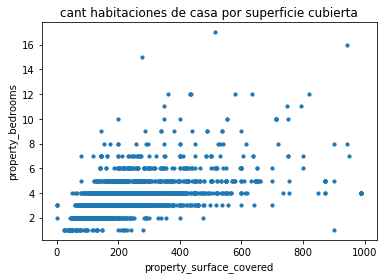

In [463]:
cant_hab_casa = viviendas_caba_train[viviendas_caba_train.property_surface_covered < 1000]
grf_bedrooms_cover_surface_casa = cant_hab_casa[cant_hab_casa.property_type=='Casa'].plot.scatter(x="property_surface_covered", y="property_bedrooms", s=10).set(title="cant habitaciones de casa por superficie cubierta",xlabel='property_surface_covered',ylabel='property_bedrooms') 


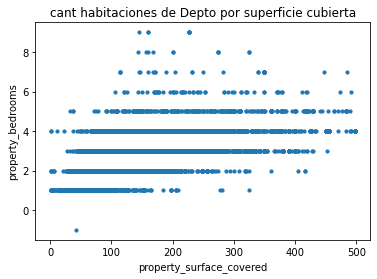

In [464]:
cant_hab_depto = viviendas_caba_train[(viviendas_caba_train.property_surface_covered < 500) & (viviendas_caba_train.property_bedrooms < 15)]

grf_bedrooms_cover_surface_depto  = cant_hab_depto[cant_hab_depto.property_type=='Departamento'].plot.scatter(x="property_surface_covered", y="property_bedrooms", s=10).set(title="cant habitaciones de Depto por superficie cubierta",xlabel='property_surface_covered',ylabel='property_bedrooms') 


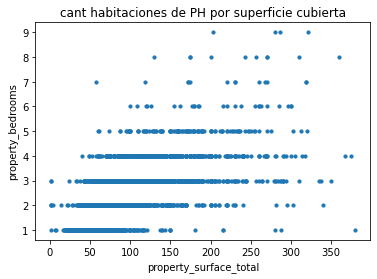

In [465]:
cant_hab_ph = viviendas_caba_train[(viviendas_caba_train.property_surface_covered < 400) & (viviendas_caba_train.property_bedrooms < 10)]
grf_bedrooms_cover_surface_ph = cant_hab_ph[cant_hab_ph.property_type=='PH'].plot.scatter(x="property_surface_covered", y="property_bedrooms", s=10).set(title="cant habitaciones de PH por superficie cubierta",xlabel='property_surface_total',ylabel='property_bedrooms') 

Despues de analizar los 3 graficos, no encontramos ninguna relacion lo suficientemente fuerte como para completar las superficies cubiertas con la cantidad de cuartos

#### Conclusiones de sobre faltantes

tenemos distintas formas de abordar los datos faltantes, algunas son las siguientes:
+ Eliminar las filas con datos faltantes
    - esta opcion es un poco "violenta"
+ Imputar datos en base a la media, moda, o mediana
    - puede quedar distorsionado según la varianza de los datos
+ Imputar en base a relacion con otra/s variables, existen distintas formas de hacer esto:
    - regresion lineal (para variables cuantitativas)
    - regresion logistica (para variables cualitativas)
    - cold-deck
    - hot-deck
    - mice
    
    #VER SI HAY MAS  y explicar cada una

Volviendo a analizar los datos faltantes por fila vemos que luego de las reparaciones mejoramos considerablemente ya que la columna con más faltantes está en un 95% completa

<AxesSubplot:title={'center':'porcentaje de datos faltantes por categoria'}, xlabel='categoria', ylabel='porcentaje'>

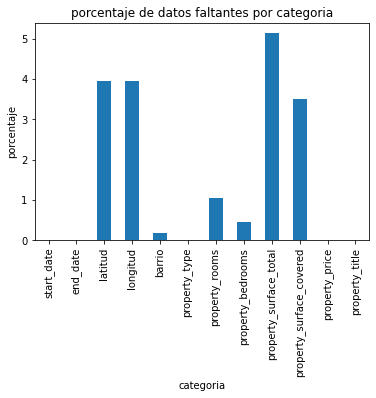

In [466]:
((viviendas_caba_train.isna().sum())/viviendas_caba_train.shape[0]*100).plot.bar(xlabel = 'categoria', ylabel = 'porcentaje', title = 'porcentaje de datos faltantes por categoria')

In [467]:
viviendas_caba_train.isnull().sum()

start_date                     0
end_date                       0
latitud                     2979
longitud                    2979
barrio                       139
property_type                  0
property_rooms               796
property_bedrooms            346
property_surface_total      3860
property_surface_covered    2637
property_price                 0
property_title                 0
dtype: int64

#### Duplicados

nos aseguramos de no tener datos duplicados en el dataset

In [468]:
duplicados = viviendas_caba_train[viviendas_caba_train.duplicated()]
duplicados

,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
6873,2021-02-09,2021-02-11,-34.633226,-58.376409,Barracas,Casa,NaN,7.0,NaN,265.0,350000.0,CASA SOBRE TERRENO PROPIO A METROS DE AVENIDA
46265,2021-04-21,2021-06-05,-34.544750,-58.461909,Nuñez,Departamento,NaN,NaN,60.0,55.0,170000.0,Departamento - Nuñez
209331,2021-11-29,2022-01-27,-34.600297,-58.462799,Paternal,Departamento,2.0,1.0,45.0,40.0,60000.0,CUCHA CUCHA 2400 2 AMB POR ESCALERA
383271,2021-04-27,2021-06-05,-34.601884,-58.373721,San Nicolás,Departamento,8.0,7.0,350.0,340.0,595000.0,OFICINAS EDIFICIO ANCHORENA
457895,2021-05-08,2021-05-24,-34.566760,-58.441816,Belgrano,Departamento,5.0,3.0,189.0,180.0,550000.0,Excelente Semipiso de 180 mts con balcón al fr...
...,...,...,...,...,...,...,...,...,...,...,...,...
14986,2021-04-22,2021-04-29,-34.587183,-58.426323,Palermo,Departamento,3.0,2.0,NaN,60.0,98000.0,"3 ambientes, muy luminoso, amplio!! Oportunidad !"
289704,2021-10-20,2022-01-27,-34.573037,-58.454206,Colegiales,PH,NaN,NaN,30.0,30.0,55000.0,PH - Colegiales
74628,2021-07-03,2021-11-03,-34.674396,-58.476608,Villa Lugano,Departamento,2.0,1.0,53.0,44.0,97460.0,Venta 2 ambientes en Lugano
273567,2021-10-25,2021-10-27,NaN,NaN,Palermo,Departamento,1.0,1.0,52.0,26.0,69000.0,Departamento - Palermo


vemos que tenemos 831 filas duplicadas pero tambien observamos que es posible tener departamentos duplicados ya que en un mismo edificio puede haber haber 2 departamentos casi identicos en cuanto a sus caracteristicas.
Por lo que decidimos solo eliminar las casas y PHs duplicadas (ya que es muy poco probable tener 2 o mas con las mismas caracterristicas, precio y barrio)

In [469]:
viviendas_caba_train.drop((duplicados[duplicados.property_type != 'Departamento']).index, axis=0, inplace=True)

vemos que eliminamos 72 viviendas duplicadas

### Valores atípicos 

##### Análisis univariadoComienzo el analisis de valores atípicos graficando atributos de forma univariada.

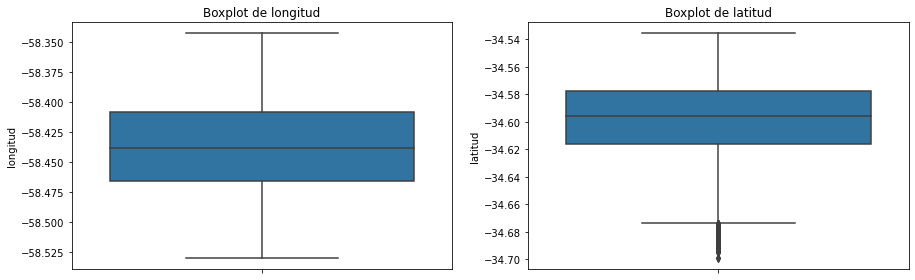

In [470]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(y="longitud", data=viviendas_caba_train).set(title = 'Boxplot de longitud' )
plt.subplot(222)
sns.boxplot(y="latitud", data=viviendas_caba_train).set(title = 'Boxplot de latitud' )
plt.show()

en cuanto a la latitud y longitud observamos que no tenemos muchos valores atípicos debido a la limpieza por poligonos que hicimos anteriormente

 ------

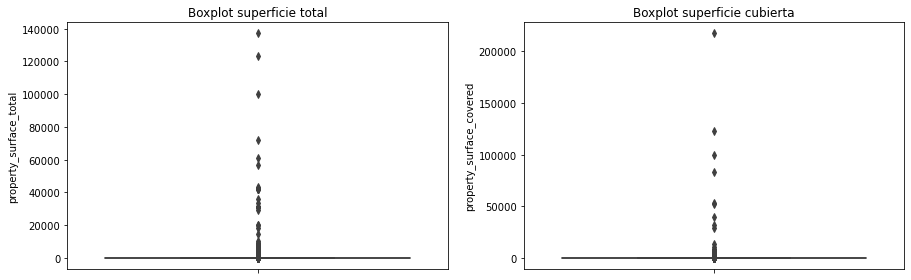

In [471]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(y="property_surface_total", data=viviendas_caba_train).set(title = 'Boxplot superficie total' )
plt.subplot(222)
sns.boxplot(y="property_surface_covered", data=viviendas_caba_train).set(title = 'Boxplot superficie cubierta' )
plt.show()

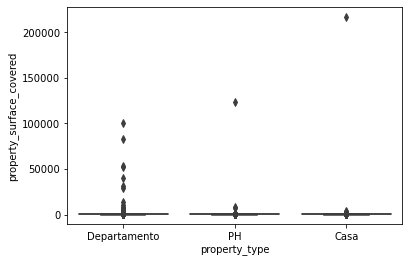

In [472]:
#ESTO ES MEJOR PROBAR
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_surface_covered)
plt.show()

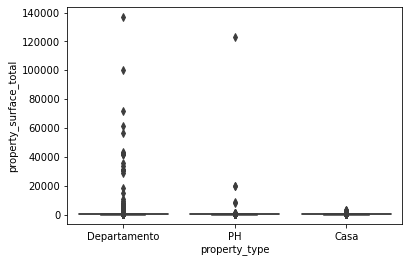

In [473]:
#ESTO ES MEJOR PROBAR
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_surface_total)
plt.show()


en cuanto a las superficies total y cubierta tenemos valores muy atípicos que hacen imposible entender el gráfico por lo que realizamos una limpieza manual

In [474]:
print(viviendas_caba_train[viviendas_caba_train.property_surface_total > 15000].shape)
viviendas_caba_train[viviendas_caba_train.property_surface_total > 15000].head(50) 
#Creo que 15000 es un buen numero para cortar porque buscando errores de unidades es raro (casi imposible) que exista una vivienda de menos de 15m^2
#El problema es que pasar los datos a mano es una paja

(25, 12)


,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
129214,2021-07-01,2200-12-31,-34.599421,-58.386867,Barrio Norte,Departamento,5.0,3.0,137000.0,135.0,390000.0,Alquiler Divino 5 Amb. - 137 M² en Barrio Norte
459847,2021-01-05,2021-01-09,-34.628247,-58.437696,Caballito,Departamento,4.0,3.0,18096.0,8568.0,324558.0,4 Ambientes Venta de Pozo Caballito Full Ameni...
362741,2021-01-16,2021-04-14,-34.579163,-58.455725,Colegiales,Departamento,1.0,1.0,31000.0,26.0,51100.0,Av. Alvarez Thomas 970 - Colegiales - Capital ...
117835,2021-08-18,2021-08-23,-34.550093,-58.483034,Saavedra,Departamento,2.0,1.0,43086.0,40038.0,114000.0,"Venta Departamento 2 amb a Estrenar, Saavedra."
324541,2021-03-03,2021-03-23,-34.628721,-58.421383,Boedo,PH,4.0,3.0,20041.0,139.0,390000.0,PH 4 AMB.C/QUINCHO Y TERRAZA AL FRENTE S/EXPENSAS
370918,2021-04-24,2021-06-05,-34.571747,-58.422612,Palermo,Departamento,4.0,3.0,42110.0,307.0,1568760.0,Reventa - Departamento - Palermo Nuevo - Liber...
219021,2021-03-07,2022-02-09,-34.636532,-58.376406,Barracas,Departamento,4.0,3.0,72060.0,90.0,210000.0,"VENTA SEMIPISO 4 AMBIENTES, EXCELENTE OPORTUIDAD"
370921,2021-04-24,2021-06-05,-34.571747,-58.422612,Palermo,Departamento,5.0,4.0,42110.0,307.0,2890500.0,Reventa - Departamento - Palermo Nuevo - Liber...
72521,2021-05-29,2021-06-13,-34.600113,-58.403649,Balvanera,Departamento,2.0,1.0,33800.0,31670.0,66000.0,VENTA 2 AMBIENTES CON RENTA
106598,2021-03-11,2021-04-20,-34.587320,-58.401556,Barrio Norte,Departamento,2.0,1.0,56740.0,52540.0,175000.0,EXCELENTE DEPARTAMENTO DE 2 AMBIENTES DE CATEG...


In [475]:
viviendas_caba_train.loc[viviendas_caba_train.index == 129214, 'property_surface_total'] = 137
viviendas_caba_train.loc[viviendas_caba_train.index == 219021, 'property_surface_total'] = 72
viviendas_caba_train.loc[viviendas_caba_train.index == 106598, 'property_surface_total'] = 56.74
viviendas_caba_train.loc[viviendas_caba_train.index == 405324, 'property_surface_total'] = 123
viviendas_caba_train.loc[viviendas_caba_train.index == 372779, 'property_surface_total'] = 100.68
viviendas_caba_train.loc[viviendas_caba_train.index == 372779, 'property_surface_total'] = 100.68

#DEBERIAMOS TRATARLOS ASI? son 20 filas con problemas de unidades aprox 
#ARREGLAR TANTO EN SUP TOT COMO EN SUP CUBIERTA

Ver si borramos esas 20 propiedades o si las arreglamos a mano

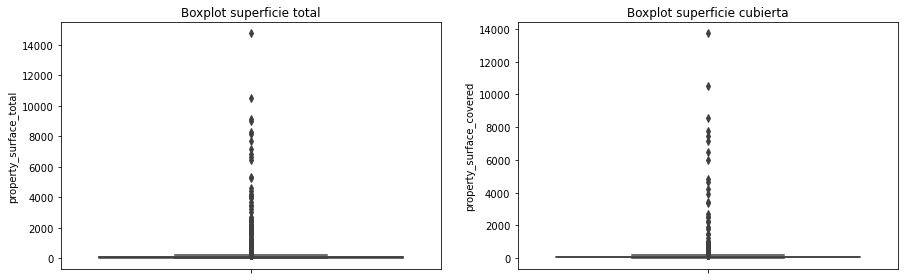

In [476]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(y="property_surface_total", data=viviendas_caba_train[viviendas_caba_train.property_surface_total<15000]).set(title = 'Boxplot superficie total' )
plt.subplot(222)
sns.boxplot(y="property_surface_covered", data=viviendas_caba_train[viviendas_caba_train.property_surface_covered<15000]).set(title = 'Boxplot superficie cubierta' )
plt.show()

Así quedarían los gráficos luego de la limpieza manual

-----

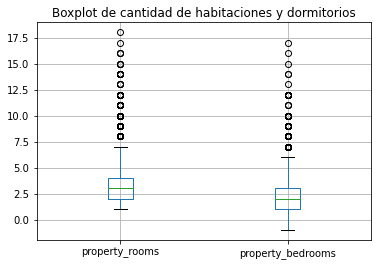

In [477]:
boxplot_rooms = viviendas_caba_train.boxplot(column = ['property_rooms','property_bedrooms']).set(title= 'Boxplot de cantidad de habitaciones y dormitorios')

en cuanto a habitaciones consideramos que es aproppiado analizar y reparar en caso de ser necesario a todas aquellas propuiedades con mas de 15 habitaciones.
Por otro lado debemos ver que se hace con las viviendas que tienen mas dormitorios que habitaciones

 -----

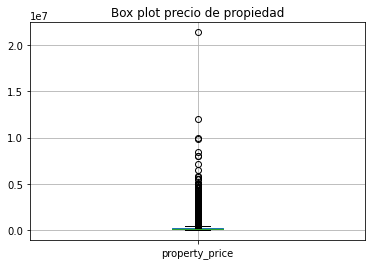

In [478]:
boxplot_price = viviendas_caba_train.boxplot(column = ['property_price']).set(title = 'Box plot precio de propiedad')

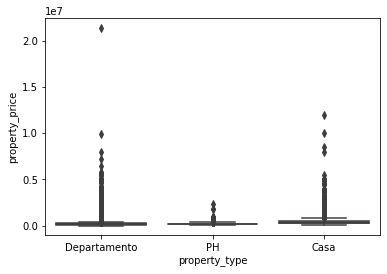

In [479]:
#ESTO ES MEJOR, PROBAR
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_price)
plt.show()

en cuanto a precio consideramos que es aproppiado analizar y reparar en caso de ser necesario a todas aquellas propuiedades con precio superior a 0.1e7 = 1Millon

 -----

De aqui se concluye:

+ Hay varios outliers en todas las variables.
+ Hay valores de superficie demasiado grandes como para pertenecer a un PH, casa, o departamento
+ Los outliers en cantidades de ambientes podrian pertenecer a casas muy grandes, deberian ser muy pocas en CABA.
+ La variedad de precios es demasiado grande, inferimos que hubieron casos de errores en la carga de los datos. 

##### Análisis multivariado

estan los graficos de arriba. ver si los ponemos de vuelta o los cambiamos de lugar

Tratamiento a aplicar:      //decidir para cada caso
+ superficie -> podriamos recortar
+ cuartos -> recortar


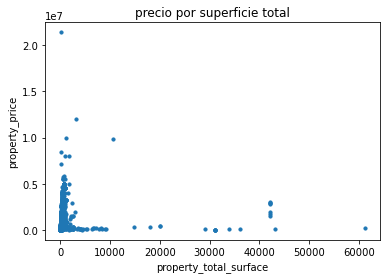

In [480]:
grf_price_surface=viviendas_caba_train.plot.scatter(x="property_surface_total", y="property_price", s=10).set(title="precio por superficie total",xlabel='property_total_surface',ylabel='property_price') 

De este grafico vemos dos cosas:
+ No se ve una correlacion a simple vista de precio-superficie total. Suponemos que se debe a que influye mas la zona que la superficie total en el precio de las propiedades.
+ Hay varios outliers previamente no detectados: 
    + Propiedades con precios extremadamente bajos y superficies enormes.
    + Propiedades con precios muy altos y superficies pequeñas.

Tambien sabemos que la mayor cantidad de propiedades se encuentran en la zona inferior izquierda del grafico. Una representacion mas precisa de esa zona podria evidenciar una relacion mas clara de los atributos. 

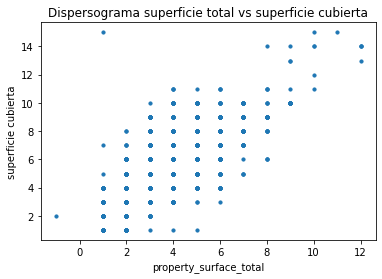

In [481]:
aux = viviendas_caba_train[viviendas_caba_train.property_surface_total < 500]
grf_sup=aux.plot.scatter(x="property_bedrooms", y="property_rooms", s=10).set(title="Dispersograma superficie total vs superficie cubierta",xlabel='property_surface_total',ylabel='superficie cubierta') 

In [482]:
viviendas_caba_train_copy.head()

,start_date,end_date,latitud,longitud,barrio,vecindad,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
256070,2021-11-03,2022-02-02,-34.566536,-58.479638,Coghlan,NaN,Departamento,2.0,1.0,65.0,53.0,198000.0,1 - Holmberg 2700
27438,2021-12-03,2022-01-27,-34.645625,-58.459408,Flores,NaN,Departamento,1.0,NaN,29.0,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...
211207,2021-11-16,2021-11-18,NaN,NaN,Caballito,NaN,Departamento,2.0,1.0,41.0,35.0,93000.0,Departamento de 2 ambientes con balcón aterraz...
228948,2021-03-08,2021-06-05,-34.577033,-58.423367,Palermo,NaN,Departamento,1.0,1.0,49.0,44.0,160000.0,Departamento - Monoambiente - Palermo Nuevo - ...
361800,2021-01-16,2021-10-09,-34.580210,-58.412815,Palermo,NaN,Departamento,1.0,2.0,NaN,78.0,290000.0,Departamento en Palermo
